## ML Model using CNN and LSTM


In [ ]:
##install
! pip install influxdb-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.1/744.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 12.7 MB/s eta 0:00:00


Library dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

load data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# List of CSV files to use for training
csv_files = ['/content/drive/MyDrive/Colab Notebooks/MLData0.csv']  # Add more file names as needed

# Load and concatenate data from multiple CSV files
data_list = []
for csv_file in csv_files:
    data = pd.read_csv(csv_file)
    data_list.append(data)

# Concatenate data from all CSV files
data = pd.concat(data_list, ignore_index=True)

In [ ]:
data

,timestamp,Total,Washer,BlowerGH,Lights,BlowerBed,CompGH,CompBed,Dryer,Recs1,Recs2,WaterHeater
0,1/18/2023 22:00,164.1,0.5,4.6,25.7,1.7,21.7,5.8,0.0,7.1,5.6,0.0
1,1/18/2023 22:01,164.3,0.5,4.6,25.6,1.7,21.7,5.8,0.0,7.1,5.6,0.0
2,1/18/2023 22:02,164.1,0.6,4.6,25.8,1.8,21.7,5.8,0.0,7.0,5.5,0.0
3,1/18/2023 22:03,164.0,0.5,4.5,25.6,1.8,21.6,5.8,0.0,7.1,5.6,0.0
4,1/18/2023 22:04,164.2,0.6,4.6,25.7,1.7,21.7,5.8,0.0,7.0,5.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5771,1/22/2023 22:11,7091.1,6.4,8.9,41.7,225.5,25.2,629.4,970.1,10.1,7.3,0.0
5772,1/22/2023 22:12,1931.8,6.0,6.3,43.4,226.8,21.1,628.1,-0.1,7.3,5.8,0.0
5773,1/22/2023 22:13,1943.2,6.0,6.4,43.5,227.9,21.2,631.0,-0.1,7.3,5.8,0.0
5774,1/22/2023 22:14,7393.9,6.4,9.2,41.9,225.9,25.6,628.0,1026.7,10.3,7.5,0.0


preprocess data

In [ ]:
# Preprocess the timestamp column to extract relevant information
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['Hour'] = data['timestamp'].dt.hour
data['DayOfWeek'] = data['timestamp'].dt.dayofweek
data['Month'] = data['timestamp'].dt.month

# Remove negative values for appropriate columns
for column in data.columns:
    if column != 'timestamp':
        data[column] = data[column].clip(lower=0)  # Clip negative values

# Remove rows with null values
data = data.dropna()
#this seems to be causing issues with the model for files that have lots of null values

define features and targets

In [ ]:
#X are the input features
X = data[['Hour', 'DayOfWeek', 'Month', 'Total']]
#Y are the output targets to predict
y = data[['Washer', 'BlowerGH', 'Lights', 'BlowerBed', 'CompGH', 'CompBed', 'Dryer', 'Recs1', 'Recs2', 'WaterHeater']]

normalization

In [ ]:
# Normalize features and targets
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)

Create sequences
-create sequences/windows of data for LSTM. Length of TIME_STEPS is used below

In [ ]:
# Function to create sequences
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps + 1):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10

# Create sequences
X_seq, y_seq = create_dataset(X, y, TIME_STEPS)

split data 80/20 for training and testing

In [ ]:
# Split data into training and testing
split_ratio = 0.8
split_index = int(len(X_seq) * split_ratio)

X_train, y_train = X_seq[:split_index], y_seq[:split_index]
X_test, y_test = X_seq[split_index:], y_seq[split_index:]

define CNN model creation

In [ ]:
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    # Add convolutional layers
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    # Reshape the data for LSTM
    model.add(tf.keras.layers.Reshape((-1, 64)))  # 64 corresponds to the number of filters in the last Conv1D layer
    # Add LSTM layers
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    # Add dense layers
    model.add(Dense(10))  # This 10 corresponds to the number of output features you have.
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and compile the model
model = create_cnn_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 32)             416       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 32)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 reshape (Reshape)           (None, 1, 64)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 50)             2

Train model

In [ ]:
#parametrs for training can be adjusted
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
289/289 [==============================] - 9s 11ms/step - loss: 0.0186 - val_loss: 0.0274
Epoch 2/10
289/289 [==============================] - 3s 9ms/step - loss: 0.0138 - val_loss: 0.0226
Epoch 3/10
289/289 [==============================] - 2s 7ms/step - loss: 0.0124 - val_loss: 0.0236
Epoch 4/10
289/289 [==============================] - 3s 10ms/step - loss: 0.0114 - val_loss: 0.0195
Epoch 5/10
289/289 [==============================] - 3s 9ms/step - loss: 0.0108 - val_loss: 0.0185
Epoch 6/10
289/289 [==============================] - 2s 7ms/step - loss: 0.0104 - val_loss: 0.0179
Epoch 7/10
289/289 [==============================] - 2s 8ms/step - loss: 0.0100 - val_loss: 0.0174
Epoch 8/10
289/289 [==============================] - 2s 8ms/step - loss: 0.0097 - val_loss: 0.0169
Epoch 9/10
289/289 [==============================] - 2s 8ms/step - loss: 0.0092 - val_loss: 0.0162
Epoch 10/10
289/289 [==============================] - 3s 11ms/step - loss: 0.0089 - val_loss: 0.0

# Testing model predictions

37/37 [==============================] - 1s 3ms/step


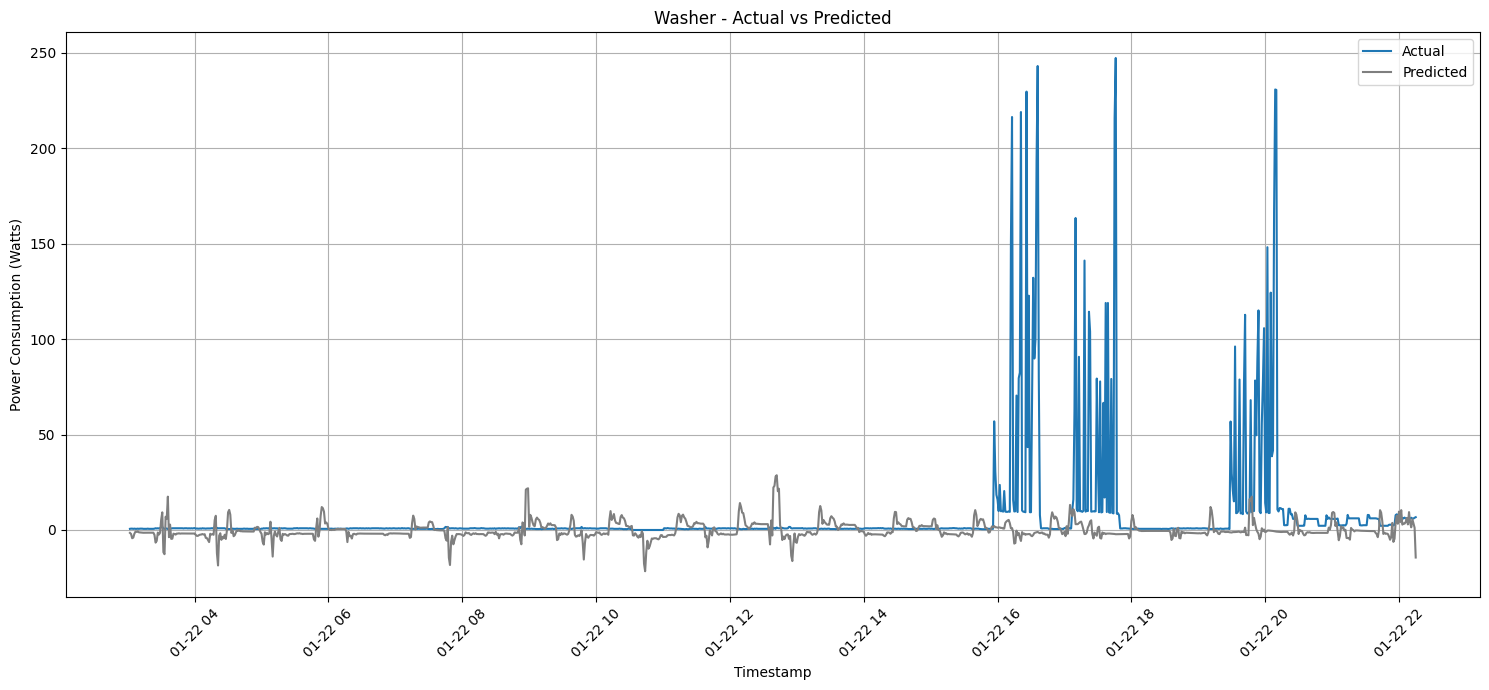

<ipython-input-13-42cf2ce01965>:43: RuntimeWarning: divide by zero encountered in divide
  absolute_percentage_error = np.abs((actual_values[:, idx] - predicted_values[:, idx]) / actual_values[:, idx])
<ipython-input-13-42cf2ce01965>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


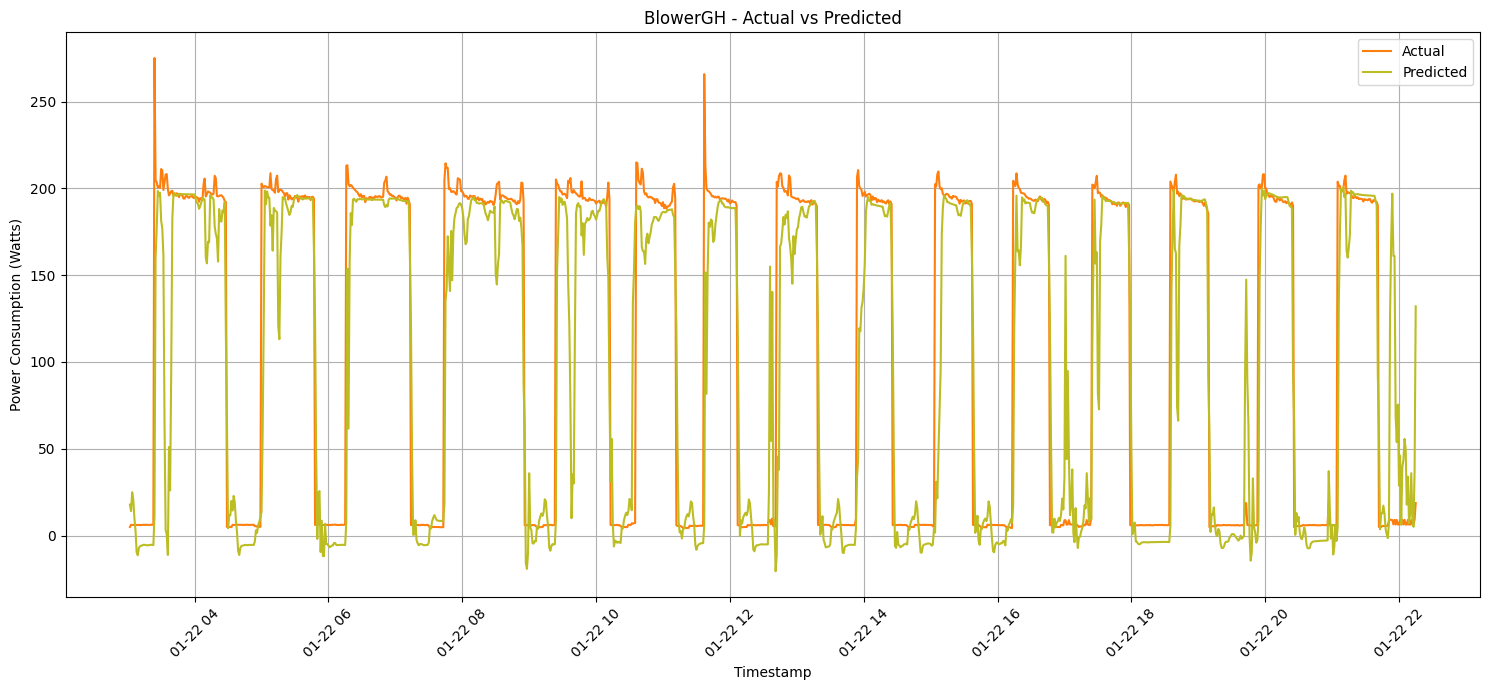

<ipython-input-13-42cf2ce01965>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


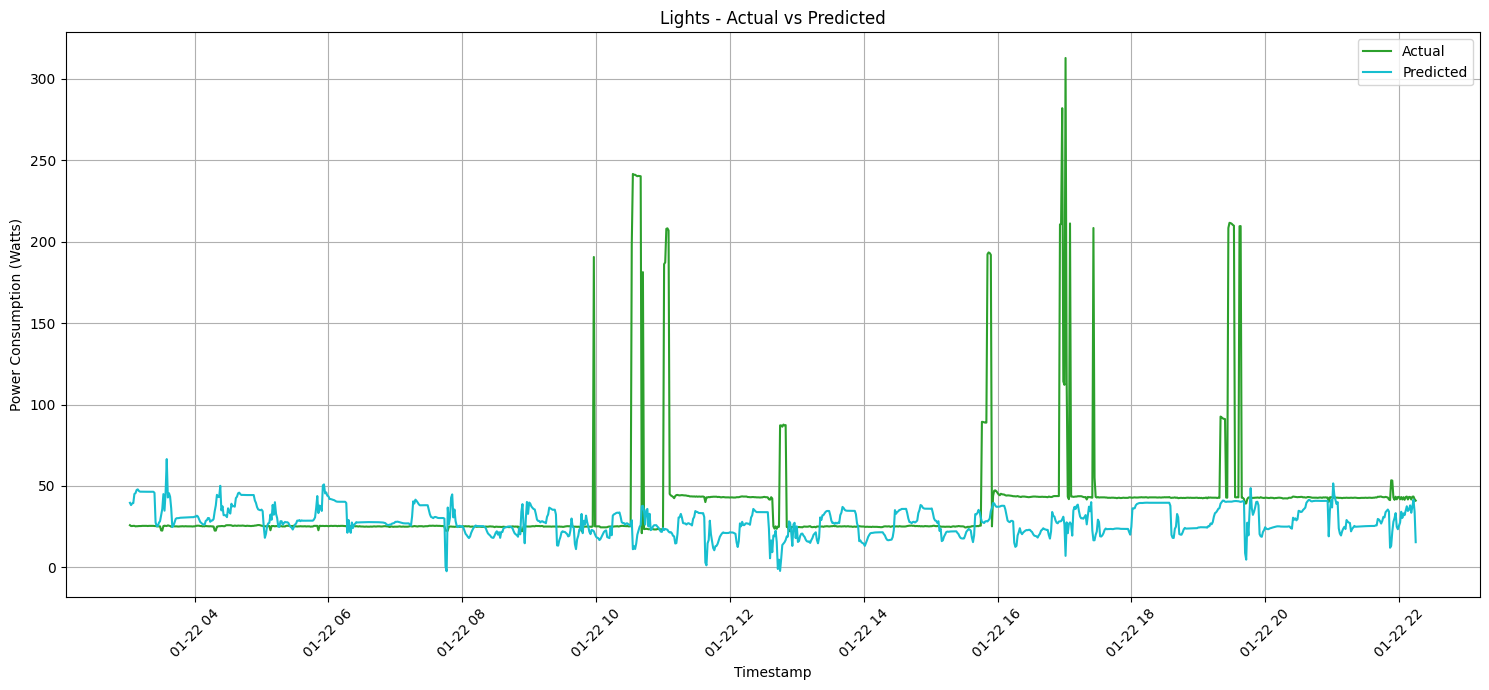

<ipython-input-13-42cf2ce01965>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


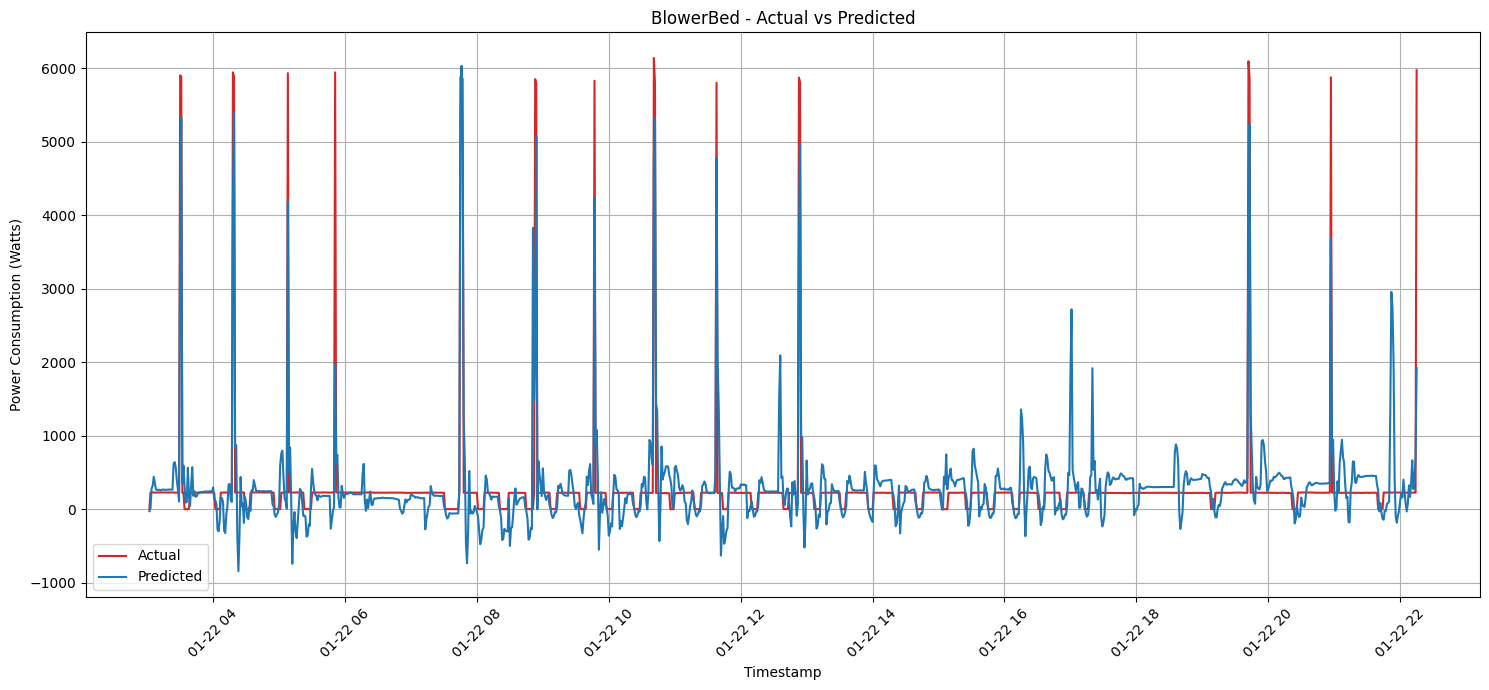

<ipython-input-13-42cf2ce01965>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


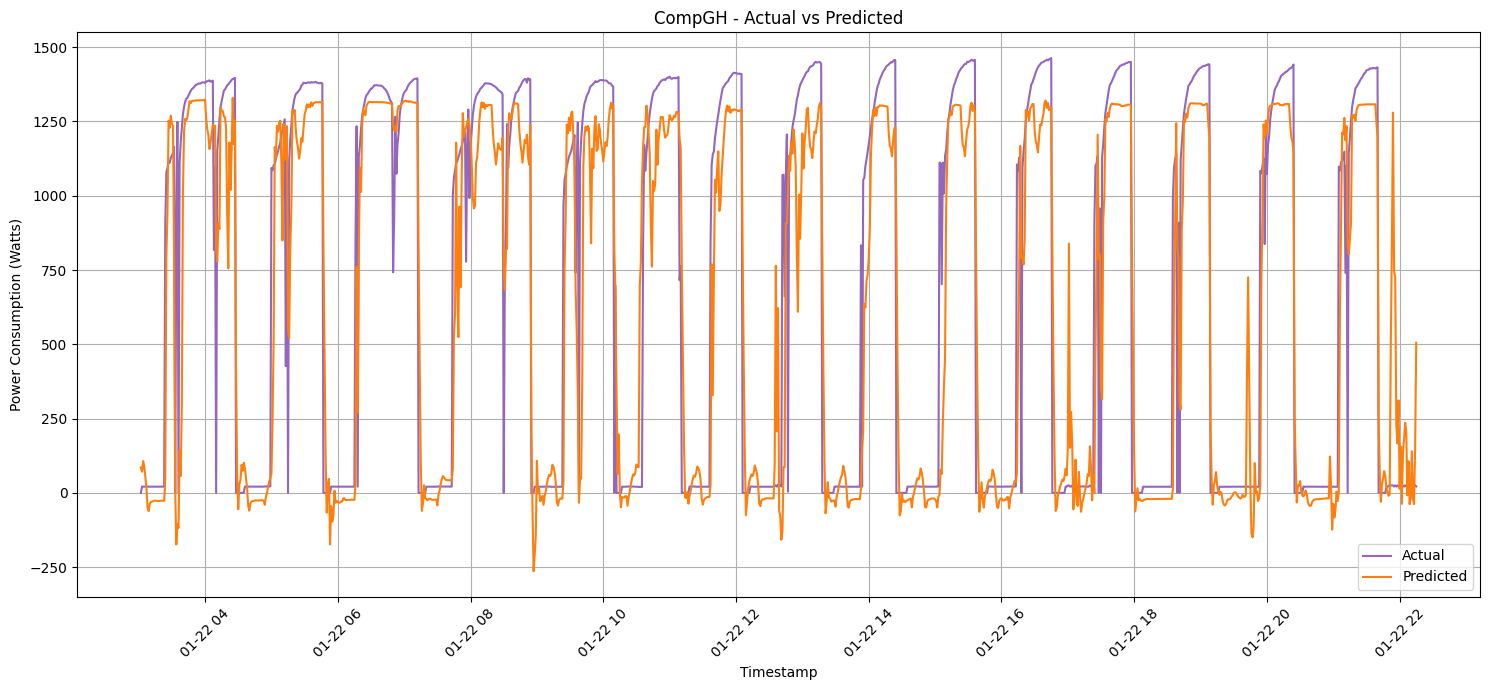

<ipython-input-13-42cf2ce01965>:43: RuntimeWarning: divide by zero encountered in divide
  absolute_percentage_error = np.abs((actual_values[:, idx] - predicted_values[:, idx]) / actual_values[:, idx])
<ipython-input-13-42cf2ce01965>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


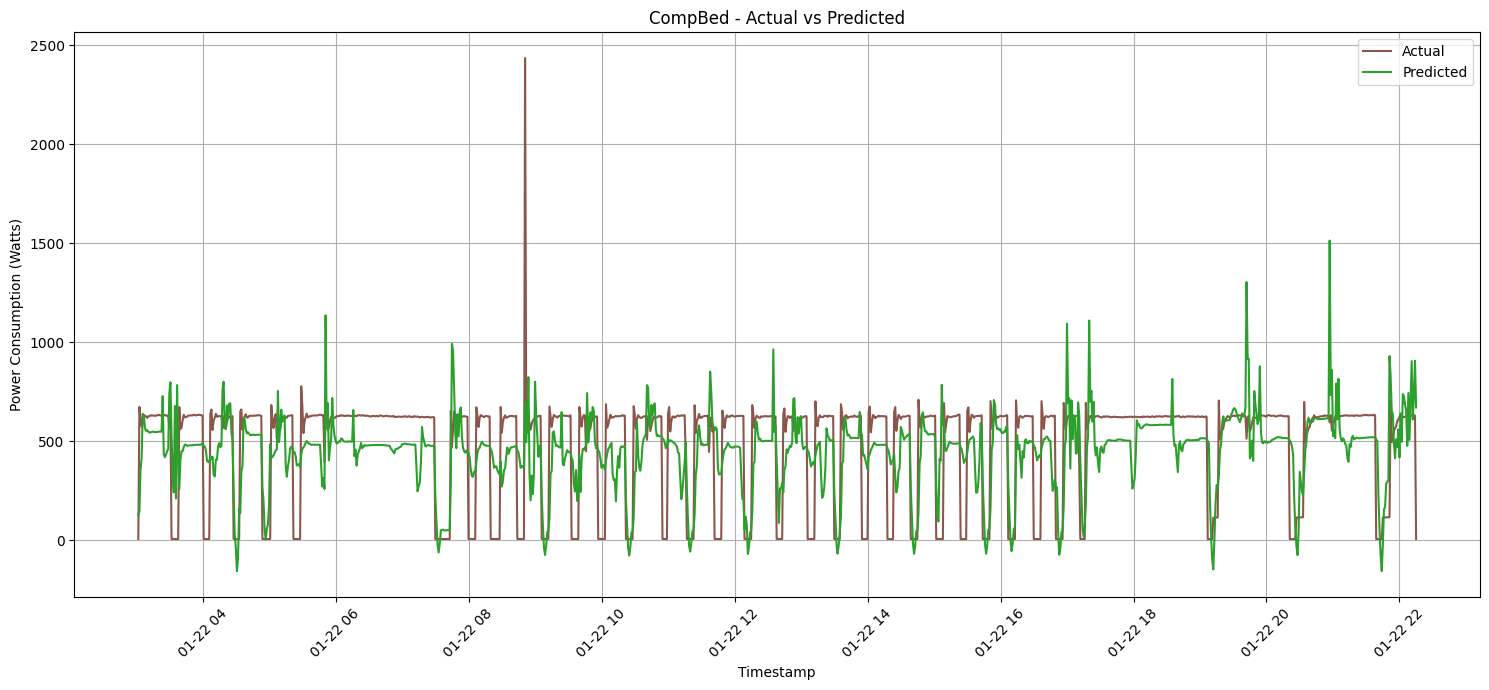

<ipython-input-13-42cf2ce01965>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


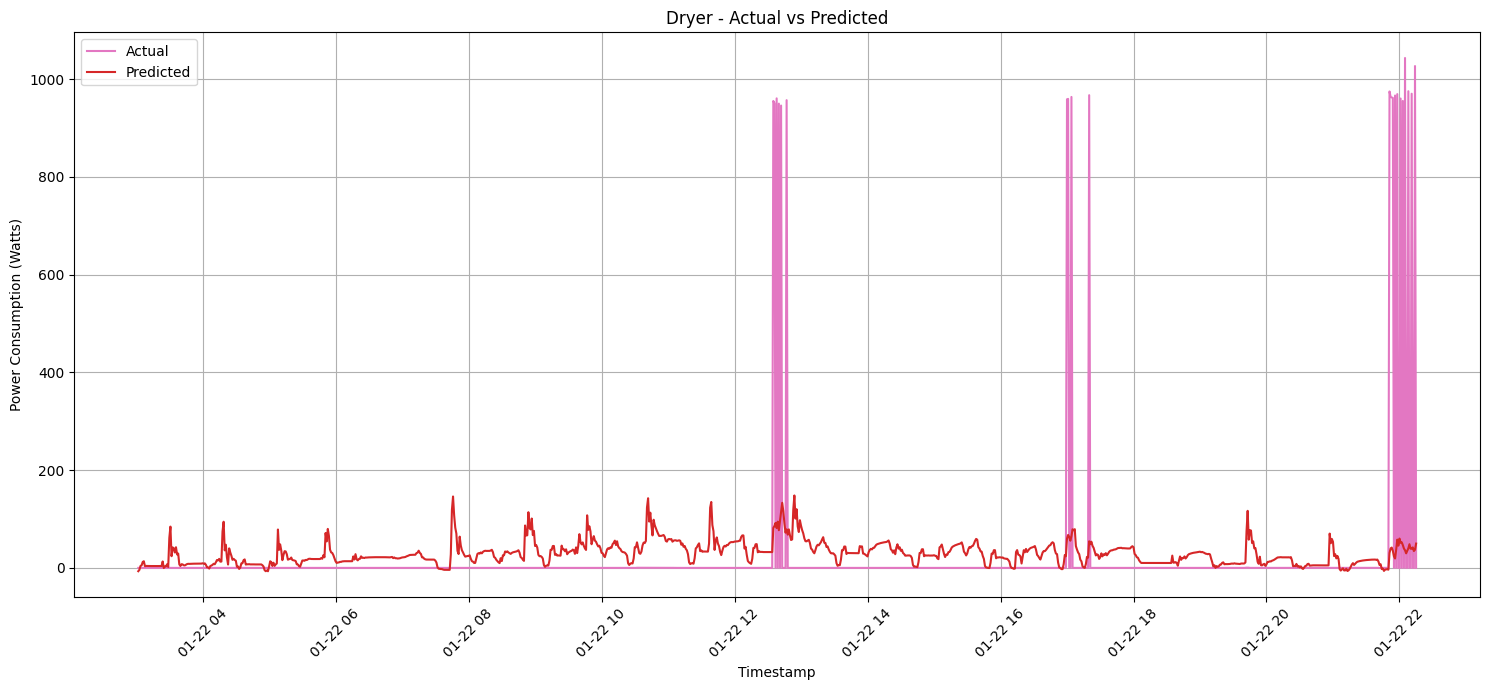

<ipython-input-13-42cf2ce01965>:43: RuntimeWarning: divide by zero encountered in divide
  absolute_percentage_error = np.abs((actual_values[:, idx] - predicted_values[:, idx]) / actual_values[:, idx])
<ipython-input-13-42cf2ce01965>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


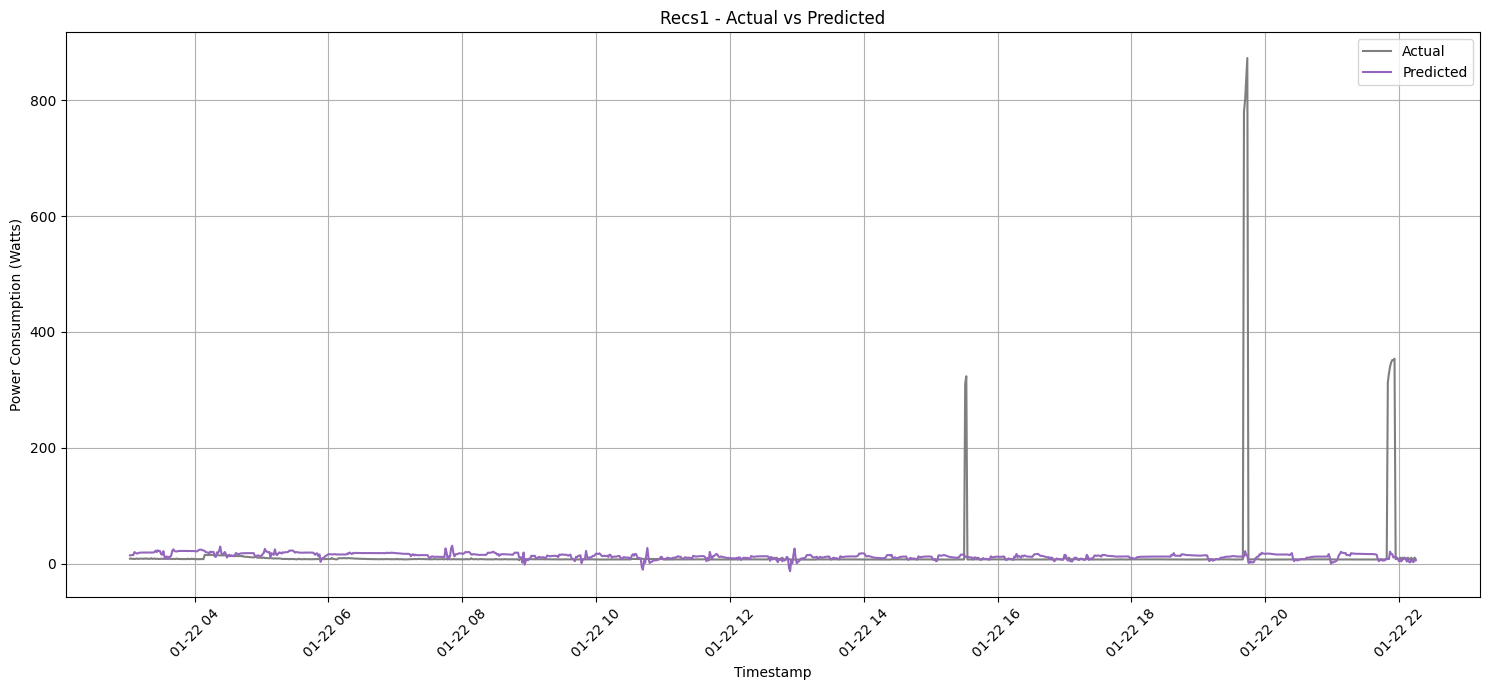

<ipython-input-13-42cf2ce01965>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


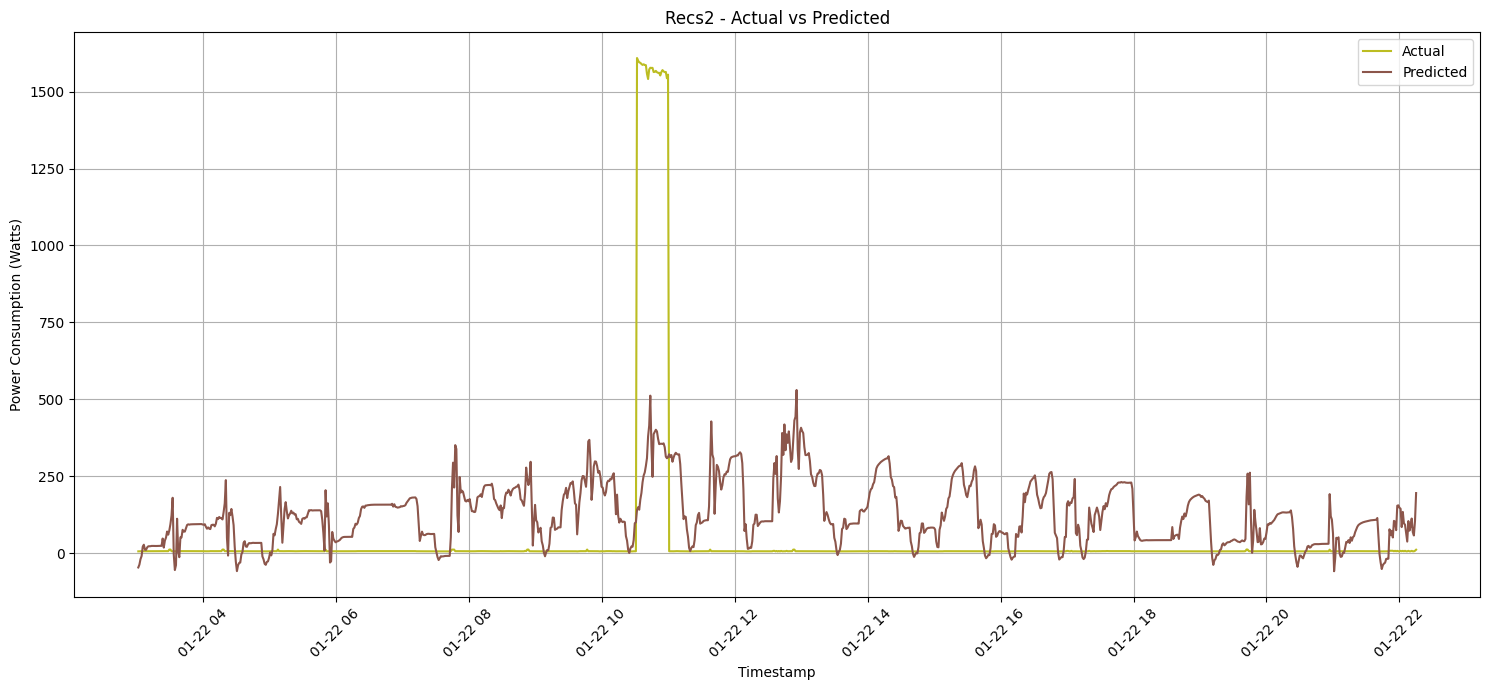

<ipython-input-13-42cf2ce01965>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


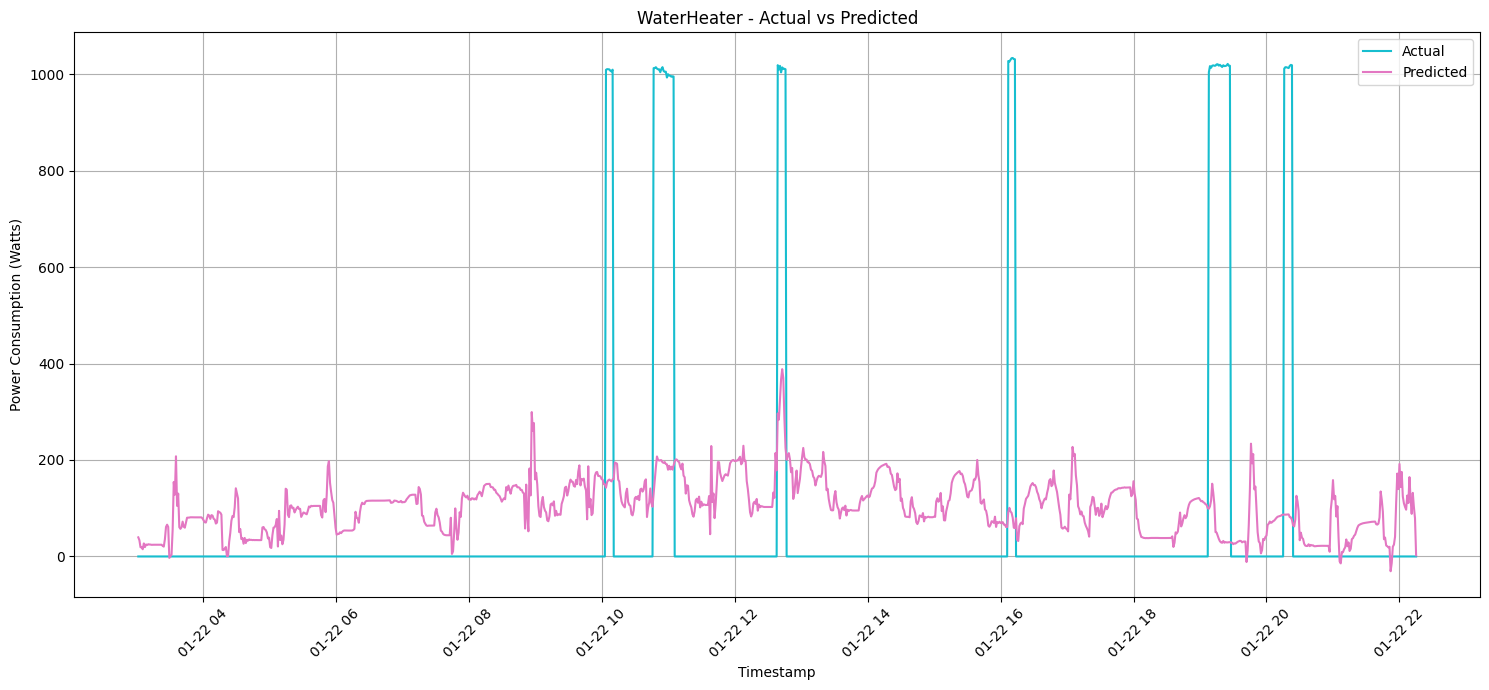

<ipython-input-13-42cf2ce01965>:43: RuntimeWarning: divide by zero encountered in divide
  absolute_percentage_error = np.abs((actual_values[:, idx] - predicted_values[:, idx]) / actual_values[:, idx])
<ipython-input-13-42cf2ce01965>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Appliance': appliance,


In [ ]:
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to get them back in Watts instead of normalized
predicted_values = scaler_y.inverse_transform(predictions)
actual_values = scaler_y.inverse_transform(y_test)

# Extract timestamps for test
test_timestamps = data['timestamp'].iloc[-len(X_test):]

appliance_names = ['Washer', 'BlowerGH', 'Lights', 'BlowerBed', 'CompGH', 'CompBed', 'Dryer', 'Recs1', 'Recs2', 'WaterHeater']

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Appliance', 'Actual Total (Watts)', 'Predicted Total (Watts)', 'Percentage Error'])


for idx, appliance in enumerate(appliance_names):
    plt.figure(figsize=(15, 7))

    # Plot actual usage
    plt.plot(test_timestamps, actual_values[:, idx], label='Actual', color='C'+str(idx))

    # Plot predicted usage
    plt.plot(test_timestamps, predicted_values[:, idx], label='Predicted', color='C'+str(idx+7))

    plt.title(f"{appliance} - Actual vs Predicted")
    plt.xlabel('Timestamp')
    plt.ylabel('Power Consumption (Watts)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate actual and predicted total power in watts for the current appliance
    actual_total = actual_values[:, idx].sum()
    predicted_total = predicted_values[:, idx].sum()

    #This was using simple error percentage, switch to MAPE
    # Calculate the percentage error for the current appliance
    percentage_error = abs(((actual_total - predicted_total) / actual_total) * 100)

    # Calculate the Mean Absolute Percentage Error (MAPE) for the current appliance
    absolute_percentage_error = np.abs((actual_values[:, idx] - predicted_values[:, idx]) / actual_values[:, idx])
    mape = np.mean(absolute_percentage_error) * 100

    # some MAPE value are extremely high due to a 0 or near 0 value for the actual at a certain point

    # Calculate the Root Mean Square Error (RMSE) for the current appliance
    rmse = np.sqrt(np.mean((actual_values[:, idx] - predicted_values[:, idx]) ** 2))

    # Calculate the Mean Absolute Error (MAE) for the current appliance
    mae = np.mean(np.abs(actual_values[:, idx] - predicted_values[:, idx]))


    # Append the results to the DataFrame
    results_df = results_df.append({'Appliance': appliance,
                                    'Actual Total (Watts)': actual_total,
                                    'Predicted Total (Watts)': predicted_total,
                                    'Percentage Error': percentage_error,
                                    'MAPE': mape,
                                    'RMSE': rmse,
                                    'MAE': mae},
                                   ignore_index=True)


In [ ]:
results_df

,Appliance,Actual Total (Watts),Predicted Total (Watts),Percentage Error,MAPE,RMSE,MAE
0,Washer,8049.6,-165.287048,102.053357,inf,28.017936,9.195004
1,BlowerGH,127317.0,116352.140625,8.612251,122.305109,41.893648,19.636057
2,Lights,44901.5,33052.062500,26.389848,33.081679,36.449425,16.483001
3,BlowerBed,335871.3,355560.062500,5.861996,1483.066604,415.685317,216.974087
4,CompGH,791660.8,715124.625000,9.667799,inf,261.320128,154.008320
5,CompBed,566683.6,519617.156250,8.305595,1029.416149,217.931912,168.320691
6,Dryer,21318.1,33847.156250,58.771918,inf,131.172593,45.871166
7,Recs1,15021.1,14907.580078,0.755736,79.418869,55.909095,11.196750
8,Recs2,52448.3,145376.906250,177.181350,1887.597416,248.868201,147.812655
9,WaterHeater,69904.7,119378.710938,70.773512,inf,241.189467,147.512476


In [ ]:
# Create an empty DataFrame to store the new results
combined_results_df = pd.DataFrame(columns=['Timestamp', 'Total'] + [f'Actual_{appliance}' for appliance in appliance_names] + [f'Predicted_{appliance}' for appliance in appliance_names])

# Iterate over the timestamps and append the values to the new DataFrame
for i, timestamp in enumerate(test_timestamps):
    # Extract actual and predicted values for each appliance at the current timestamp
    actual_values_at_timestamp = actual_values[i]
    predicted_values_at_timestamp = predicted_values[i]

    # Calculate total actual and predicted values
    total_actual = actual_values_at_timestamp.sum()
    total_predicted = predicted_values_at_timestamp.sum()

    # Create a dictionary to store the values for the current timestamp
    row_values = {'Timestamp': timestamp, 'Total': total_actual}

    # Add actual values for each appliance to the dictionary
    for idx, appliance in enumerate(appliance_names):
        row_values[f'Actual_{appliance}'] = actual_values_at_timestamp[idx]

    # Add predicted values for each appliance to the dictionary
    for idx, appliance in enumerate(appliance_names):
        row_values[f'Predicted_{appliance}'] = predicted_values_at_timestamp[idx]

    # Append the values to the new DataFrame
    combined_results_df = combined_results_df.append(row_values, ignore_index=True)


<ipython-input-15-93373bd4b929>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_results_df = combined_results_df.append(row_values, ignore_index=True)
<ipython-input-15-93373bd4b929>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_results_df = combined_results_df.append(row_values, ignore_index=True)
<ipython-input-15-93373bd4b929>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_results_df = combined_results_df.append(row_values, ignore_index=True)
<ipython-input-15-93373bd4b929>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_results_df = combined_results_df.append(row_values, ignore_index=Tr

In [ ]:
combined_results_df['Timestamp'] = combined_results_df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Find and replace '2023' with '2024' in the 'timestamp' column
combined_results_df['Timestamp'] = combined_results_df['Timestamp'].str.replace('2023', '2024')

# Convert 'timestamp' back to datetime format
combined_results_df['Timestamp'] = pd.to_datetime(combined_results_df['Timestamp'])

In [ ]:
combined_results_df

,Timestamp,Total,Actual_Washer,Actual_BlowerGH,Actual_Lights,Actual_BlowerBed,Actual_CompGH,Actual_CompBed,Actual_Dryer,Actual_Recs1,...,Predicted_Washer,Predicted_BlowerGH,Predicted_Lights,Predicted_BlowerBed,Predicted_CompGH,Predicted_CompBed,Predicted_Dryer,Predicted_Recs1,Predicted_Recs2,Predicted_WaterHeater
0,2024-01-22 03:02:00,52.6,0.6,4.9,25.9,2.0,0.0,5.3,0.0,8.3,...,-1.528420,17.762424,39.635178,-25.739748,85.482498,126.443512,-6.770332,14.136104,-46.779957,39.610073
1,2024-01-22 03:03:00,968.6,0.7,6.2,25.4,227.8,21.1,672.7,0.0,8.8,...,-2.069216,14.045224,38.262138,11.061325,71.238556,145.579727,-3.967022,14.330777,-37.619846,33.630173
2,2024-01-22 03:04:00,910.3,0.7,6.1,25.4,227.5,21.0,615.6,0.0,8.1,...,-4.333214,24.919773,39.300529,283.639191,107.165565,354.614410,4.138477,14.848227,-19.732761,19.126564
3,2024-01-22 03:05:00,867.3,0.6,6.1,25.5,228.5,21.0,571.6,0.0,8.1,...,-3.981197,20.660133,39.472569,318.343628,89.706665,412.751556,5.229976,14.562125,-9.550080,19.238091
4,2024-01-22 03:06:00,911.4,0.7,6.1,25.5,229.9,20.9,614.3,0.0,8.1,...,-1.921683,10.061251,45.074348,441.164276,53.640579,637.011169,12.178144,19.772552,20.452938,14.949981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,2024-01-22 22:11:00,1924.6,6.4,8.9,41.7,225.5,25.2,629.4,970.1,10.1,...,1.384713,35.954300,33.556427,666.406311,140.118454,903.464722,39.133556,6.589216,112.245171,88.321770
1150,2024-01-22 22:12:00,944.8,6.0,6.3,43.4,226.8,21.1,628.1,0.0,7.3,...,5.657420,9.831472,37.231850,273.672607,-19.430956,608.784119,41.911682,3.359350,68.183311,131.820526
1151,2024-01-22 22:13:00,949.1,6.0,6.4,43.5,227.9,21.2,631.0,0.0,7.3,...,3.531225,5.014363,41.465950,392.965515,-37.847752,724.148743,34.533966,2.584499,57.156536,102.493118
1152,2024-01-22 22:14:00,1981.5,6.4,9.2,41.9,225.9,25.6,628.0,1026.7,10.3,...,1.187027,37.508316,34.275024,694.767151,147.357498,905.235657,37.168755,7.900442,104.472679,79.372375


In [ ]:
token = "I3HpkHLls_07_PBiu6uErE8nmdQb-FkETe1VyTQ4HGMbty-6NGNki1vocbE3mTTNZ0NA08cpUJg17q-wzzoqGQ=="
org = "NCSU"
bucket = "ML Data"

# InfluxDB Cloud URL
cloud_url = "https://us-east-1-1.aws.cloud2.influxdata.com"

# Establish InfluxDB connection
client = InfluxDBClient(url=cloud_url, token=token, org=org)

# Check if 'timestamp' and 'value' columns are present
if 'Timestamp' not in combined_results_df.columns:
    raise ValueError("Column 'Timestamp' is required in the DataFrame.")

# Convert DataFrame to InfluxDB Points
points = combined_results_df.apply(lambda row: Point("CDR Demo")
                                     .field("Total", row["Total"])
                                     .field("Actual_Washer", row["Actual_Washer"])
                                     .field("Predicted_Washer", row["Predicted_Washer"])
                                     .field("Actual_BlowerGH", row["Actual_BlowerGH"])
                                     .field("Predicted_BlowerGH", row["Predicted_BlowerGH"])
                                     .field("Actual_Lights", row["Actual_Lights"])
                                     .field("Predicted_Lights", row["Predicted_Lights"])
                                     .field("Actual_BlowerBed", row["Actual_BlowerBed"])
                                     .field("Predicted_BlowerBed", row["Predicted_BlowerBed"])
                                     .field("Actual_CompGH", row["Actual_CompGH"])
                                     .field("Predicted_CompGH", row["Predicted_CompGH"])
                                     .field("Actual_CompBed", row["Actual_CompBed"])
                                     .field("Predicted_CompBed", row["Predicted_CompBed"])
                                     .field("Actual_Dryer", row["Actual_Dryer"])
                                     .field("Predicted_Dryer", row["Predicted_Dryer"])
                                     .field("Actual_Recs1", row["Actual_Recs1"])
                                     .field("Predicted_Recs1", row["Predicted_Recs1"])
                                     .field("Actual_Recs2", row["Actual_Recs2"])
                                     .field("Predicted_Recs2", row["Predicted_Recs2"])
                                     .field("Actual_WaterHeater", row["Actual_WaterHeater"])
                                     .field("Predicted_WaterHeater", row["Predicted_WaterHeater"])
                                     .time(row["Timestamp"]), axis=1)

# Create a write API instance
write_api = client.write_api(write_options=SYNCHRONOUS)

# Write Points to InfluxDB
write_api.write(bucket=bucket, record=points)